In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

## Task:

## EEG Data

In [11]:
FILE = '2018-10-05-nile_eyes_closed_raw.csv'

In [12]:
EEGmeta = list()
with open(FILE, 'r') as csvfile:
    for row in range(0,15):
        EEGmeta.append(csvfile.readline())

In [13]:
EEGmeta

['# Mains_Frequency_(Hz) =,60,,,,,,,,,,\n',
 '# Sample_Frequency_(Hz) =,300,,,,,,,,,,\n',
 '# Filter_Delay_(ms) =,43.3,,,,,,,,,,\n',
 '# Sensor_Data_Units =,uV,,,,,,,,,,\n',
 '# Headset_Name =,DSI-7 SN:7656,,,,,,,,,,\n',
 '# Data_Logger =,DSI-Streamer-v.1.08.36,,,,,,,,,,\n',
 '# Date =,10/5/2018,,,,,,,,,,\n',
 '# Time =,12:57:06,,,,,,,,,,\n',
 '# Patient_ID =,X F 01-MAY-1999 X,,,,,,,,,,\n',
 '# Record_ID =,Startdate 05-OCT-2018 EEG_XX X X,,,,,,,,,,\n',
 '# Filter =,Non-Filtered,,,,,,,,,,\n',
 '# Comments =,,,,,,,,,,,\n',
 '# Reference location:,Oz,,,,,,,,,,\n',
 '# Trigger Source,Wireless,,,,,,,,,,\n',
 '# Channel_Number =,ch_1,ch_2,ch_3,ch_4,ch_5,ch_6,ch_7,Trigger,Time_Offset,ADC_Status,ADC_Sequence,Event,Comments\n']

In [14]:
EEGmeta[1].split(',')

['# Sample_Frequency_(Hz) =', '300', '', '', '', '', '', '', '', '', '', '\n']

In [15]:
fs = int(EEGmeta[1].split(',')[1])

## Get EEG data

In [16]:
EEGdata = pd.read_csv(FILE,',',skiprows = 15)

In [18]:
EEGdata.head()

,Time,LE,F4,C4,PO8,PO7,C3,F3,Trigger,Time_Offset,ADC_Status,ADC_Sequence,Event,Comments
0,0.0033,-396.3,-310.5,-389.1,414.9,337.8,-1187.4,-618.3,0,6,0,51,0,Start Data Acquisition
1,0.0067,-403.8,-315.9,-386.4,410.1,333.9,-1183.8,-620.4,0,12,0,52,0,NaN
2,0.0100,-463.2,-374.1,-443.7,357.3,292.2,-1243.2,-677.1,0,18,0,53,0,NaN
3,0.0133,-462.9,-380.7,-442.8,348.6,288.3,-1250.4,-679.8,0,24,0,54,0,NaN
4,0.0167,-436.5,-357.3,-421.2,377.4,308.7,-1229.4,-655.5,0,30,0,55,0,NaN


## Visualizing the Data

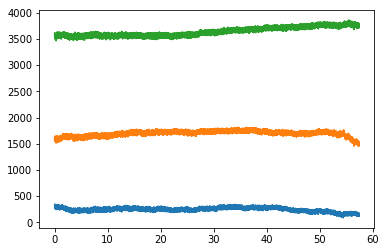

In [20]:
plt.plot(EEGdata['Time'], EEGdata['PO7'])
plt.plot(EEGdata['Time'], EEGdata['C4']+2000)
plt.plot(EEGdata['Time'], EEGdata['LE']+4000)

plt.show()

## Subplots

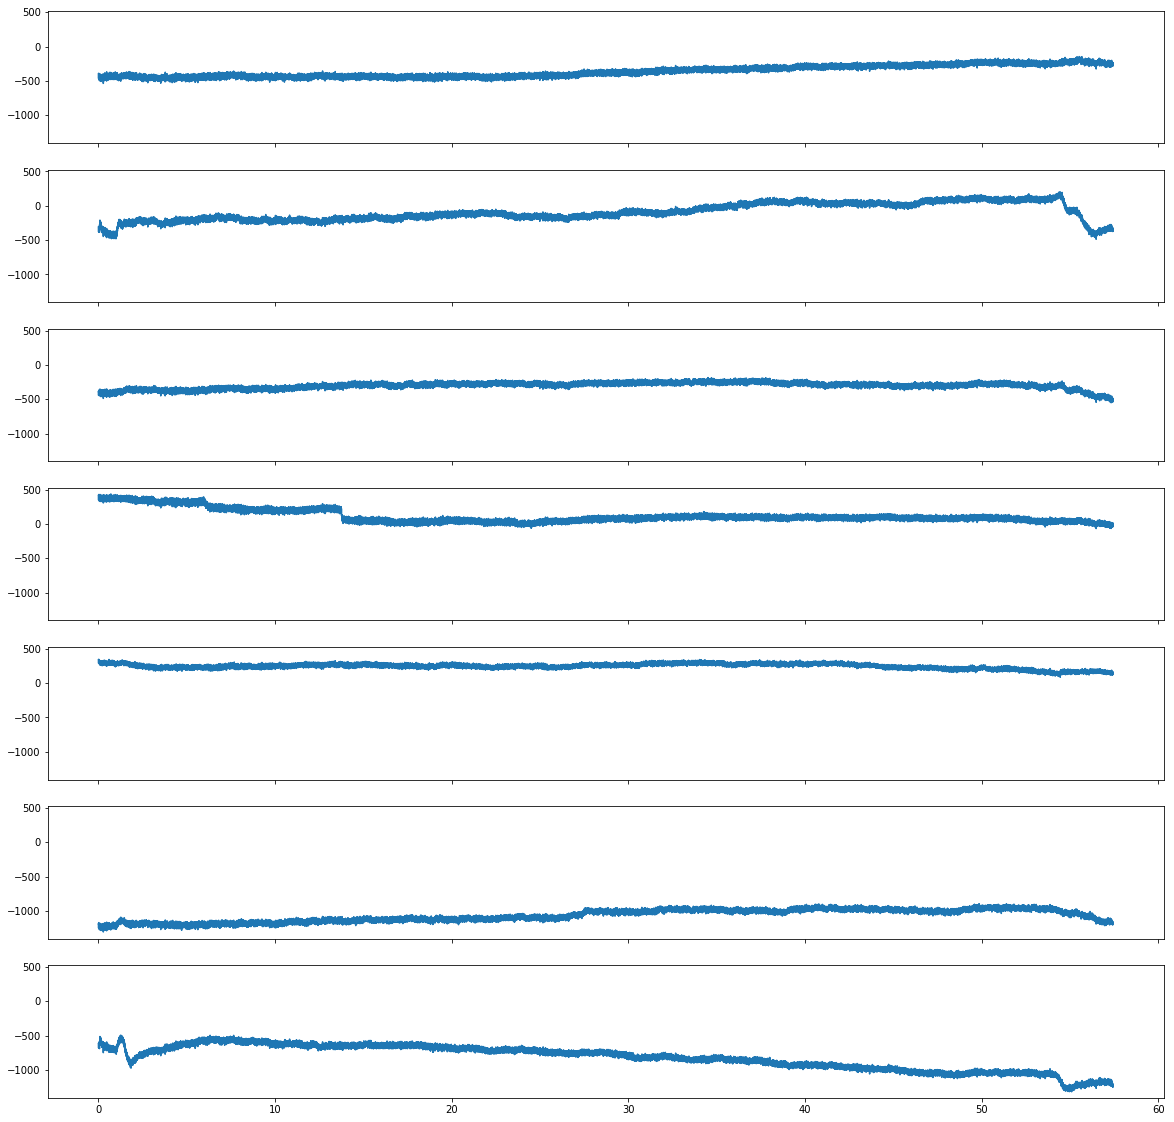

In [21]:
fig, axes = plt.subplots(nrows = 7, ncols = 1, sharex = True, sharey = True)
for i in range (7):
    axes[i].plot(EEGdata['Time'], EEGdata[EEGdata.columns[1+i]])
fig.set_size_inches(20, 20)
plt.show()

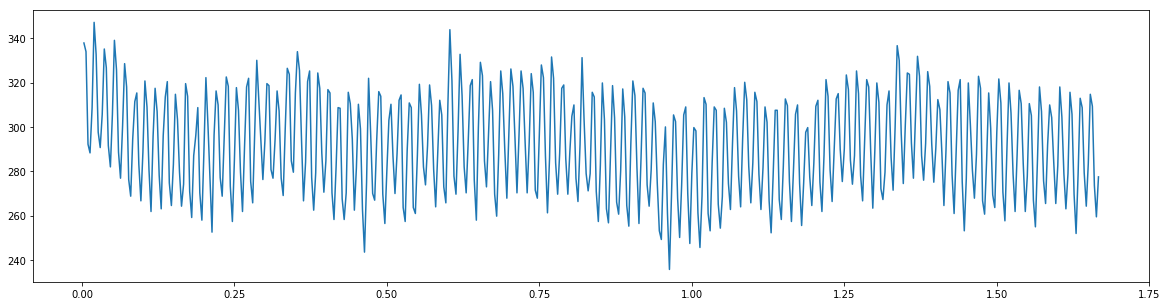

In [22]:
#Just looking at the first 500 samples (About 1.6 seconds)
fig = plt.figure()
plt.plot(EEGdata['Time'][:500], EEGdata['PO7'][:500])
fig.set_size_inches(20,5)
plt.show()

# Filtering the Data

In [23]:
import scipy.signal as scisig  
def butter_bandpass(low, high, fs, order=4):
    """
    Wrapper function for the scipy butter
    :param low: Frequency to filter above
    :param high: Frequency to filter below
    :param fs: Sampling rate (hz)
    :param order: Order of filter to use (default = 4)
    :return: Numerator (b) and denominator (a) polynomials of the IIR filter
    """
    nyq = 0.5 * fs
    b, a = scisig.butter(order, [low / nyq, high / nyq], btype='band')
    return b, a

def butter_bandpass_filter(data, low, high, fs, order=4):
    """
    Filters passed data with a bandpass butter function
    :param data: data to be bandpass filtered
    :param low: Frequency to filter above
    :param high: Frequency to filter below
    :param fs: Sampling rate (hz)
    :param order: Order of filter to use (default = 4)
    :return: filtered data (and modifies original data).
    """
    b, a = butter_bandpass(low, high, fs, order=order)
    # data = data - np.mean(data)
    return scisig.filtfilt(b, a, data)

In [26]:
# Filter the data
lowpass_value = 8 # Hz
highpass_value = 12 # Hz

n_samples = EEGdata.shape[0]
n_channels = 7

EEGdata_filt = np.zeros((n_channels, n_samples))

# Use i+1 in .columns to skip the first column (time)
for i in range(0, n_channels):
    EEGdata_filt[i] = butter_bandpass_filter(EEGdata[EEGdata.columns[i+1]], lowpass_value,\
                                      highpass_value, fs, order=4)

# Transpose back into samples x channels
EEGdata_filt = np.transpose(EEGdata_filt)

/usr/local/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [27]:
(EEGdata_filt).shape

(17228, 7)

In [28]:
EEGdata_filt = pd.DataFrame(data = EEGdata_filt, columns=EEGdata.columns[1:8])
EEGdata_filt['Time']=EEGdata['Time']

### Visualize it...

In [29]:
 EEGdata_filt

,LE,F4,C4,PO8,PO7,C3,F3,Time
0,-0.594720,0.565799,-0.385601,-0.454311,0.670259,-0.179649,1.416055,0.0033
1,-1.376758,-1.532071,-0.861358,-1.309961,-0.321560,-0.342020,0.650226,0.0067
2,-2.099737,-3.557498,-1.306704,-2.123209,-1.275517,-0.472400,-0.137636,0.0100
3,-2.737467,-5.447859,-1.710067,-2.867485,-2.146745,-0.571174,-0.941619,0.0133
4,-3.267365,-7.145755,-2.061146,-3.518573,-2.895409,-0.640583,-1.753902,0.0167
5,-3.671323,-8.600628,-2.351111,-4.055362,-3.488661,-0.684396,-2.563988,0.0200
6,-3.936379,-9.770138,-2.572774,-4.460496,-3.902179,-0.707508,-3.358181,0.0233
7,-4.055167,-10.621286,-2.720731,-4.720889,-4.121228,-0.715488,-4.119373,0.0267
8,-4.026124,-11.131237,-2.791472,-4.828108,-4.141200,-0.714090,-4.827180,0.0300
9,-3.853454,-11.287856,-2.783458,-4.778604,-3.967595,-0.708785,-5.458455,0.0333


## RAW Vs. FILTERED DATA

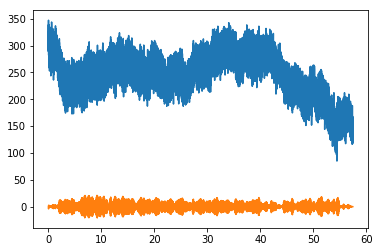

In [30]:
plt.plot(EEGdata['Time'], EEGdata['PO7'])
plt.plot(EEGdata_filt['Time'], EEGdata_filt['PO7'])
plt.show()
#Raw is blue data 
#Filtered is orange data

In [31]:
# Filter into the alpha band
lowpass_value = 8
highpass_value = 12

EEGdata_alpha = np.zeros((n_channels, n_samples))

# Use i+1 in .columns to skip the first column (time)
for i in range(0, n_channels):
    EEGdata_alpha[i] = butter_bandpass_filter(EEGdata[EEGdata.columns[i+1]], lowpass_value,\
                                      highpass_value, fs, order=4)

# Transpose back into samples x channels
EEGdata_alpha = np.transpose(EEGdata_alpha)

# Add column headers and time
EEGdata_alpha = pd.DataFrame(data=EEGdata_alpha, columns=EEGdata.columns[1:8])
EEGdata_alpha['Time'] = EEGdata['Time']

/usr/local/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [32]:
# Filter into the beta band
lowpass_value = 12
highpass_value = 30

EEGdata_beta = np.zeros((n_channels, n_samples))

# Use i+1 in .columns to skip the first column (time)
for i in range(0, n_channels):
    EEGdata_beta[i] = butter_bandpass_filter(EEGdata[EEGdata.columns[i+1]], lowpass_value,\
                                      highpass_value, fs, order=4)

# Transpose back into samples x channels
EEGdata_beta = np.transpose(EEGdata_beta)

# Add column headers and time
EEGdata_beta = pd.DataFrame(data=EEGdata_beta, columns=EEGdata.columns[1:8])
EEGdata_beta['Time'] = EEGdata['Time']

/usr/local/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


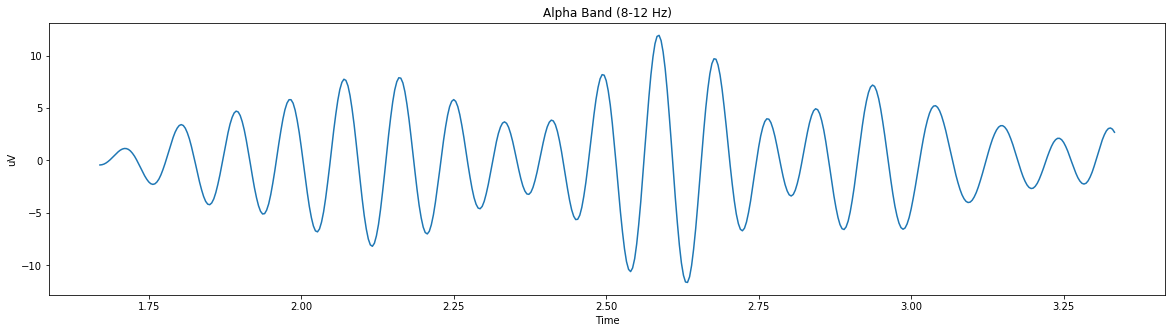

In [34]:
fig =plt.figure()
fig.set_size_inches(20,5)
plt.plot(EEGdata_alpha['Time'][500:1000], EEGdata_alpha['LE'][500:1000])
plt.title('Alpha Band (8-12 Hz)')
plt.xlabel('Time')
plt.ylabel('uV')
plt.show()

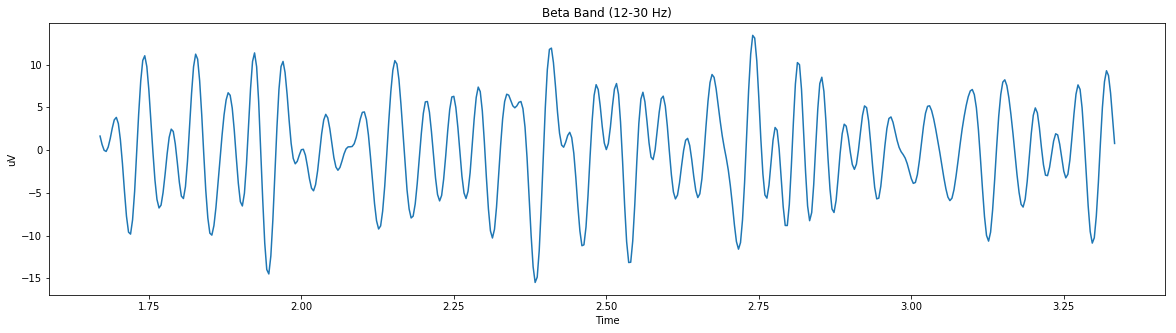

In [36]:
fig = plt.figure()
fig.set_size_inches(20,5)
plt.plot(EEGdata_beta['Time'][500:1000], EEGdata_beta['LE'][500:1000])
plt.title('Beta Band (12-30 Hz)')
plt.xlabel('Time')
plt.ylabel('uV')
plt.show()

## Power!

In [37]:
alpha_power = abs(scisig.hilbert(EEGdata_alpha[EEGdata_alpha.columns[:7]]))**2
alpha_power = pd.DataFrame(data = alpha_power, columns=EEGdata.columns[1:8])
alpha_power['Time']=EEGdata['Time']

/usr/local/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


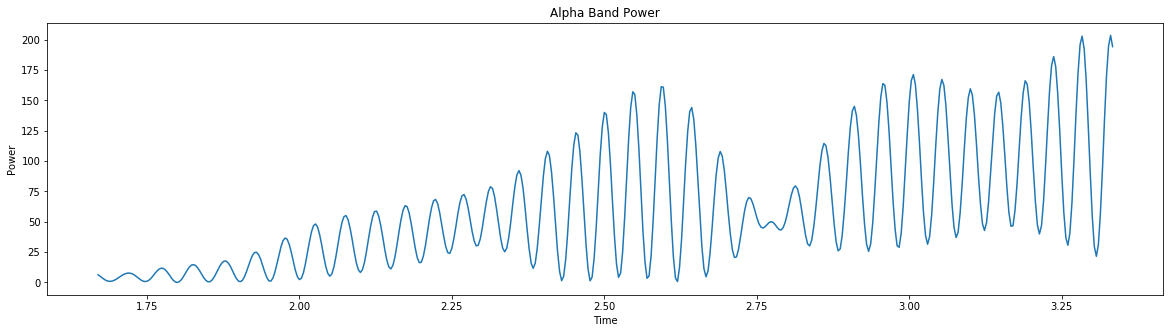

In [44]:
fig = plt.figure()
fig.set_size_inches(20, 5)
plt.plot(alpha_power['Time'][500:1000],alpha_power['C3'][500:1000])
plt.title('Alpha Band Power')
plt.xlabel('Time')
plt.ylabel('Power')
plt.show()

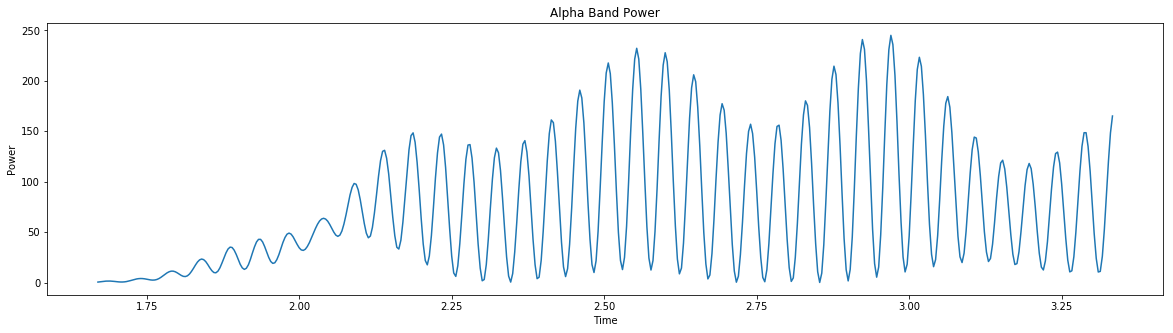

In [45]:
fig = plt.figure()
fig.set_size_inches(20, 5)
plt.plot(alpha_power['Time'][500:1000],alpha_power['C4'][500:1000])
plt.title('Alpha Band Power')
plt.xlabel('Time')
plt.ylabel('Power')
plt.show()

In [40]:
beta_power = abs(scisig.hilbert(EEGdata_beta[EEGdata_beta.columns[:7]]))**2
beta_power = pd.DataFrame(data=beta_power, columns=EEGdata.columns[1:8])
beta_power['Time'] = EEGdata['Time']

/usr/local/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


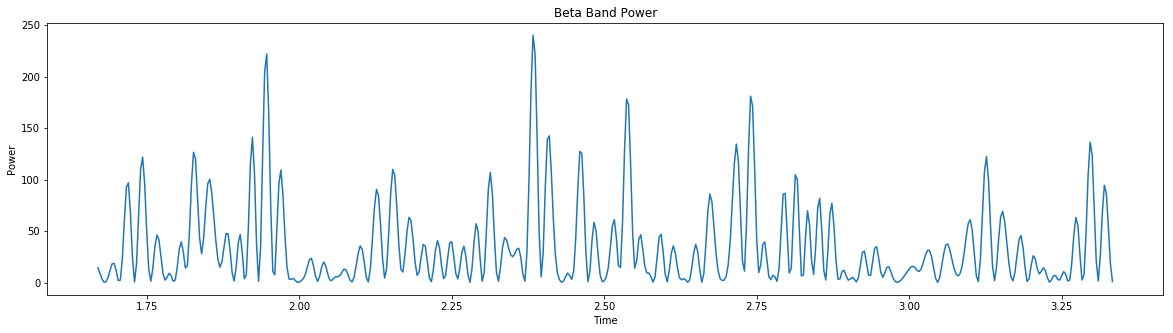

In [42]:
fig = plt.figure()
fig.set_size_inches(20, 5)
plt.plot(beta_power['Time'][500:1000],beta_power['LE'][500:1000])
plt.title('Beta Band Power')
plt.xlabel('Time')
plt.ylabel('Power')
plt.show()

## Epochs

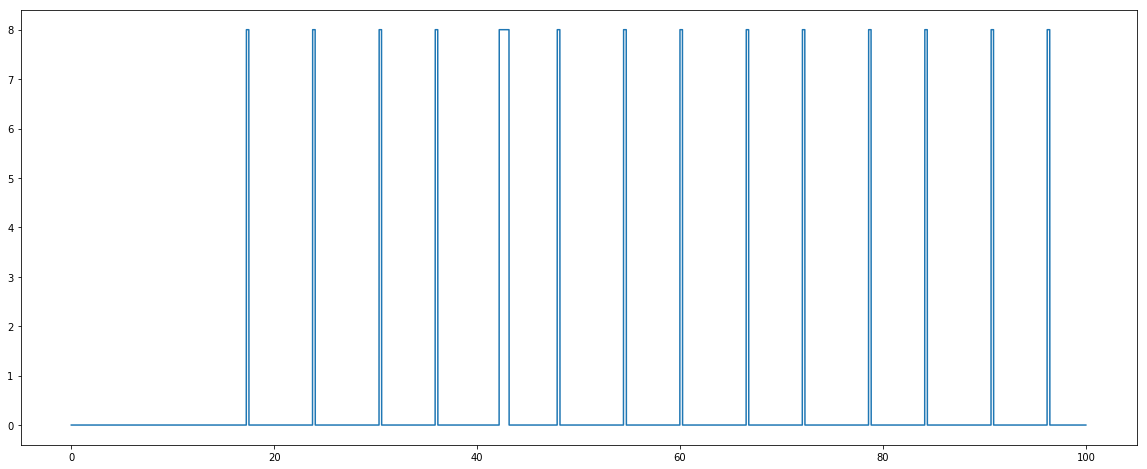

In [53]:
fig = plt.figure()
#x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

plt.plot(EEGdata['Time'][:30000],EEGdata['Trigger'][:30000])
fig.set_size_inches(20, 8)
plt.show()

## Offset by Initial sync pulse

In [30]:
# Store where the values in trigger are equal to 8 (the audio trigger input channel number)
idx_trigger = np.where(EEGdata['Trigger']==8)

print('idx_trigger contains ' + str(idx_trigger[0].shape) + ' sample index values')
idx_trigger[0][:100] # print the first 100 points

idx_trigger contains (3391,) sample index values


array([5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185,
       5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196,
       5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207,
       5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218,
       5219, 5220, 5221, 5222, 5223, 5224, 5225, 5226, 5227, 5228, 5229,
       5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240,
       5241, 5242, 5243, 5244, 5245, 5246, 5247, 5248, 5249, 7134, 7135,
       7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7144, 7145, 7146,
       7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157,
       7158], dtype=int64)

In [31]:
# Store the sample number of the beginning of the very first pulse
t0 = idx_trigger[0][0]

print('Initial sync pulse is at sample '+ str(t0) +' in the EEG data')

Initial sync pulse is at sample 5175 in the EEG data


In [32]:
#t0 + (float(behavioralData['trialStart'][0])*fs)

In [33]:
print('We estimate trial_0 to start at sample ' + str(t0))

We estimate trial_0 to start at sample 5175


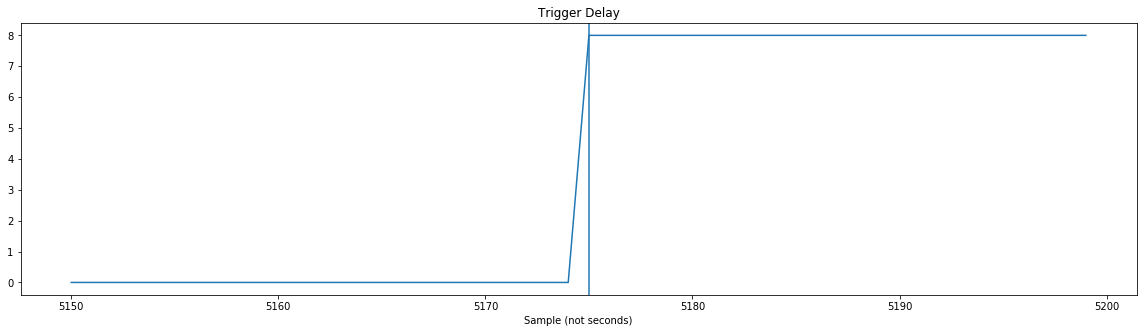

In [34]:
tmp = t0
fig = plt.figure()
plt.plot(EEGdata['Trigger'][tmp-25:tmp+25])
plt.axvline(x=tmp)
fig.set_size_inches(20, 5)
plt.xlabel('Sample (not seconds)')
plt.title('Trigger Delay')
plt.show()

In [35]:
# Initial peak/jump detection (note that it isn't clean all the time so just take initial)
idx_trigger = np.where(np.diff(EEGdata['Trigger'])>1) #use EEGdata['Trigger'] to make sure we get initial

# Check to see the starting sample number for each trigger pulse
idx_trigger

(array([ 5174,  7133,  9099, 10758, 12650, 14366, 16327, 17994, 19954,
        21615, 23573, 25234, 27195, 28853, 30814, 32468, 34429, 36088,
        38048, 39708, 41669, 43330, 45288, 46948, 48908, 50567, 52528,
        54189, 56147, 57807, 59767, 61428, 63387, 65048, 67007, 68667,
        70627, 72289, 74248, 75908, 77868, 79527], dtype=int64),)

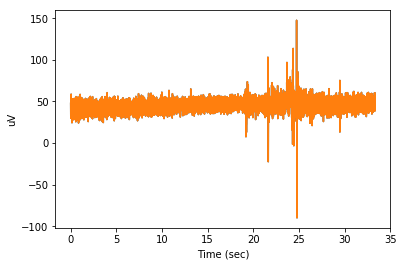

In [69]:
plt.plot(EEGdata['Time'][1:10000],EEGdata['PO7'][1:10000])
plt.plot(EEGdata_filt['Time'][1:10000],EEGdata['PO7'][1:10000])
plt.ylabel('uV')
plt.xlabel('Time (sec)')
plt.show()

In [ ]:
plt.plot(EEGdata['Time'][1:10000],EEGdata['PO7'][1:10000])
plt.plot(EEGdata_filt['Time'][1:10000],EEGdata['PO7'][1:10000])
plt.ylabel('uV')
plt.xlabel('Time (sec)')
plt.show()

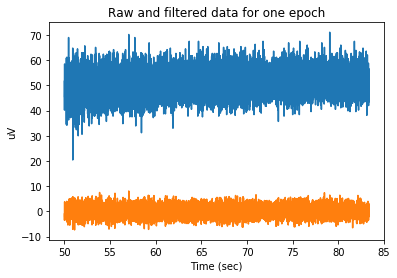

In [60]:
#15 - 25
plt.plot(EEGdata['Time'][15000:25000], EEGdata['PO7'][15000:25000])
plt.plot(EEGdata_filt['Time'][15000:25000],EEGdata_filt['PO7'][15000:25000])
plt.title('Raw and filtered data for one epoch')
plt.ylabel('uV')
plt.xlabel('Time (sec)')
plt.show()

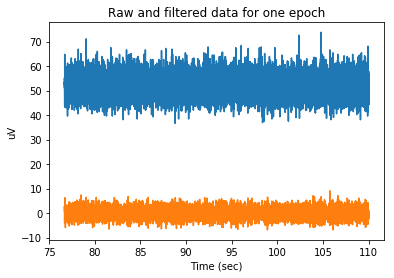

In [61]:
#15 - 25
plt.plot(EEGdata['Time'][23000:33000], EEGdata['PO7'][23000:33000])
plt.plot(EEGdata_filt['Time'][23000:33000],EEGdata_filt['PO7'][23000:33000])
plt.title('Raw and filtered data for one epoch')
plt.ylabel('uV')
plt.xlabel('Time (sec)')
plt.show()